# Dataset preparation

## Mount Google drive
download dataset from Google Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##Download Dataset into Google instance
copy dataset zip file from Google Drive to Colab istance (because online reading from Google Drive during training is very slow)

In [ ]:
!mkdir -p dataset

In [ ]:
!cp gdrive/My\ Drive/MachineLearningProjects/data/impervious_surface_extraction/v1_0_test.zip .

In [ ]:
!unzip v1_0_test.zip -d dataset

Archive:  v1_0_test.zip
   creating: dataset/v1_0_test/
   creating: dataset/v1_0_test/gt/
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_0_244_244.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_10004_244_10248.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_10248_244_10492.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_10492_244_10736.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_10736_244_10980.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_1220_244_1464.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_1464_244_1708.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_1708_244_1952.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_1952_244_2196.tif  
  inflating: dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_201

# Install libraries

##RasterIO

In [ ]:
!pip install rasterio

     |████████████████████████████████| 18.2MB 166kB/s 


## FastAI

In [ ]:
!curl https://course.fast.ai/setup/colab | bash

from fastai.utils.collect_env import *
show_install(True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   4410      0 --:--:-- --:--:-- --:--:--  4410
Updating fastai...
Done.


```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.1+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensi

#Import libraries

In [ ]:
from fastai.vision import *
from fastai.utils.mem import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
from skimage import io
from fastai.vision.models.xresnet import *
import rasterio
from fastai.vision.learner import cnn_config # notice this extra import 
from fastai.callbacks import *
import pdb

# Configuration Constants

In [ ]:
DATASET_PATH = '/content/dataset/v1_0_test'
MODEL_PATH = '/content/gdrive/My Drive/MachineLearningProjects/models/impervious_surface_extraction'

path_dataset = Path(DATASET_PATH)

path_img = path_dataset
path_lbl = path_dataset/'gt'

path_dataset.ls()

[PosixPath('/content/dataset/v1_0_test/gt'),
 PosixPath('/content/dataset/v1_0_test/train')]

# FastAI customization

##ItemList

In [ ]:
def _load_mask(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image)->Image:
    x = rasterio.open(fn).read(1) # read first band
    x[ (x >= 2) & (x <= 9) ] = 0
    x[ (x >= 10) & (x <= 19) ] = 1
    x[ (x >= 20) & (x <= 29) ] = 0
    x[ (x >= 100) & (x <= 199) ] = 1
    x[ (x >= 200) & (x <= 299) ] = 0
    x[x <= 0] = 0
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

def load_mask(fn:PathOrStr, div=False, convert_mode='L')->ImageSegment:
    "Return `ImageSegment` object create from mask in file `fn`. If `div`, divides pixel values by 255."
    return _load_mask(fn, div=div, convert_mode=convert_mode, cls=ImageSegment)

def _open(fn):
    raw = rasterio.open(fn).read()
    raw = raw[(0,1,2), :, :]
    #arrays = [rasterio.open(sat_img_name_prefix + "_B" + str(i).zfill(2) + ".jp2").read(1) for i in self.bands]
    x = torch.from_numpy(raw.astype(np.float32, copy=False))
    return x

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return load_mask(fn)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.bands = bands
        # if bands is not None:
        #   self.bands = (1)
       
    def open(self, fn): return _open (fn)
        

## Get mask
Function to get Path Ground Truth from training chip

In [ ]:
def get_y_fn (x):
    if (isinstance(x, str)):
        x = Path(x)
    ground_truth_name = 'GT_' + x.stem 
    return path_lbl/(ground_truth_name + '.tif')

name = get_y_fn(Path('C:/test/L2A_T33TVF_A009228_20170329T095024_0_4880_244_5124.tif'))
print(name)

/content/dataset/v1_0_test/gt/GT_L2A_T33TVF_A009228_20170329T095024_0_4880_244_5124.tif


# Various Checks

Check ability to read Training Set

In [ ]:
fnames = get_image_files(path_img/'train', check_ext=False)
fnames[:3]

[PosixPath('/content/dataset/v1_0_test/train/L2A_T33TVF_A009228_20170329T095024_488_5124_732_5368.tif'),
 PosixPath('/content/dataset/v1_0_test/train/L2A_T33TVF_A009228_20170329T095024_3416_5612_3660_5856.tif'),
 PosixPath('/content/dataset/v1_0_test/train/L2A_T33TVF_A009228_20170329T095024_8296_7564_8540_7808.tif')]

Check ability to read Ground Truth

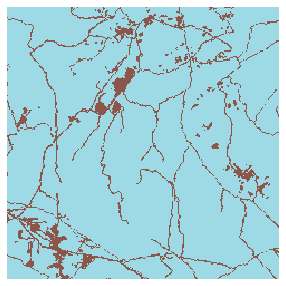

In [ ]:
mask = load_mask(get_y_fn('L2A_T33TVF_A009228_20170329T095024_0_4880_244_5124.tif'))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
img = _open(path_img/'train/L2A_T33TVF_A009228_20170329T095024_0_4880_244_5124.tif')
print(img.shape)
# print(img)

torch.Size([3, 244, 244])


# Model definition

Choose batch size regarding GPU memory

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10701MB of GPU RAM free


#Dataset Loading

In [ ]:
# the classes corresponding to each channel
codes = array(['NoData', 'Impervious'])

ImageDataBunch;

Train: LabelList (1279 items)
x: SegItemListCustom
tensor([[[ 410.,  473.,  615.,  ..., 1055.,  881.,  782.],
         [ 406.,  462.,  616.,  ...,  869., 1004.,  894.],
         [ 501.,  565.,  631.,  ...,  578.,  821., 1001.],
         ...,
         [ 820.,  877.,  750.,  ..., 1294., 1426., 1353.],
         [ 719.,  778.,  639.,  ..., 1160., 1504., 1057.],
         [ 531.,  544.,  538.,  ...,  774., 1111.,  853.]],

        [[ 375.,  387.,  464.,  ..., 1055.,  873.,  761.],
         [ 326.,  364.,  428.,  ...,  925., 1037.,  952.],
         [ 386.,  428.,  432.,  ...,  602.,  793.,  983.],
         ...,
         [ 687.,  759.,  665.,  ...,  982., 1074., 1055.],
         [ 609.,  659.,  558.,  ...,  853., 1194.,  855.],
         [ 494.,  513.,  470.,  ...,  646.,  978.,  774.]],

        [[ 206.,  239.,  321.,  ...,  883.,  673.,  507.],
         [ 237.,  233.,  297.,  ...,  792.,  944.,  771.],
         [ 260.,  301.,  314.,  ...,  379.,  606.,  924.],
         ...,
 

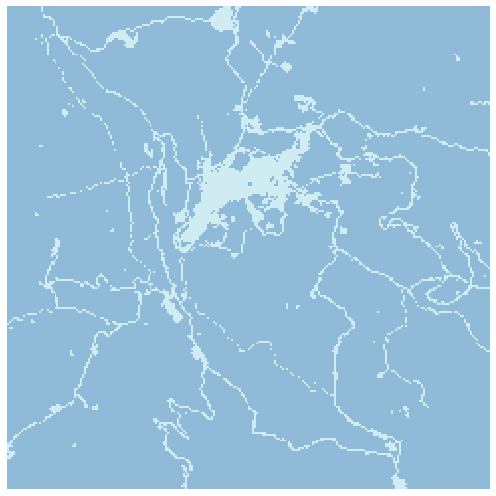

In [ ]:
size = 244

data = SegItemListCustom.from_folder(path_img/'train', extensions=['.tif', '.TIF'])
# data = data.split_by_folder()
data = data.split_by_rand_pct(valid_pct=0.2, seed=123456)
data = data.label_from_func(get_y_fn, classes=codes)
data = data.databunch(bs=bs)
data.show_batch(1, figsize=(10,7))
data

In [ ]:
data.train_ds[0][0].shape #check shape input

torch.Size([3, 244, 244])

# Define custom losses and metrics 
Here we implement some new loss functions like Dice Loss and Focal Loss which have been shown to perform well in image segmentation tasks. Then we'll create a MultiChComboLoss class to combine multiple loss functions and calculate them across the 3 channels with adjustable weighting.

The approach of combining a Dice or Jaccard loss to consider image-wide context with individual pixel-focused Binary Cross Entropy or Focal loss with adjustable weighing of the target mask channels has been shown to consistently outperform single loss functions. 

Finally, we adapt our model evaluation metrics (accuracy and dice score) to calculate a mean score for all channels or by a specified individual channel.

In [ ]:
from fastai.vision import *
from fastai.utils.mem import *


def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.
    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """

    # print('input.shape' + str(input.shape))

    # input_ = torch.unsqueeze(input, 1)
    input_ = input
    # print('input_.shape: ' + str(input_.shape))

    # Shape (N, num_classes, *)
    shape = np.array(input_.shape)
    shape_lst = list(shape)
    shape_lst[1] = num_classes
    shape = tuple(shape_lst)

    result = torch.zeros(shape)
    # print('result.shape: ' + str(result.shape))

    result = result.scatter_(1, input_.cpu(), 1)

    # return result.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return to_device(result, defaults.device)
    # return result


def accuracy_void(input, target, void_code=None):
    # pdb.set_trace()
    target = target.squeeze(1)
    if void_code is None:
        accuracy = (input.argmax(dim=1) == target).float().mean()
    else:
        mask = target != void_code
        # N.B.: mask sono tutti 0 se nel target ho tutti 0 e mi da errore perché poi ho NaN
        accuracy = (input.argmax(dim=1)[mask] == target[mask]).float().mean()
    # if (torch.isnan(accuracy)):
    #   accuracy = 1
    return accuracy


def bce_loss(logits, labels):
    # print('logits.shape: ' + str(logits.shape))
    logits = logits[:, 1, :, :].float()
    labels = labels.squeeze(1).float()
    # print('labels.shape: ' + str(labels.shape))

    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)

    return bce_loss

def dice_loss(input, target):
    #     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() + smooth))


# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(), DiceLoss()], loss_wts=[1, 1], ch_wts=[1, 1, 1],
                 target_hot_encoded=True):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs
        self.target_hot_encoded = target_hot_encoded

    def forward(self, output, target):
        #         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction  # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        # print("output.shape MultiChComboLoss: " + str(output.shape))
        # print("target.shape MultiChComboLoss: " + str(target.shape))
        if not self.target_hot_encoded:
            target = make_one_hot(target, channels)

        # print("target.shape hot encoded MultiChComboLoss: " + str(target.shape))
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt, c in zip(self.ch_wts, range(channels)):
            ch_loss = 0
            for loss_wt, loss_func in zip(self.loss_wts, self.loss_funcs):
                ch_loss += loss_wt * loss_func(output[:, c, None], target[:, c, None])
            loss += ch_wt * (ch_loss)
        return loss / sum(self.ch_wts)


# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input: Tensor, target: Tensor, thresh: float = 0.5, sigmoid: bool = True,
                       one_ch: int = None) -> Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."

    num_classes = input.shape[1]
    target_channels = target.shape[1]

    if num_classes != target_channels:
        target = make_one_hot(target, num_classes)

    #     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]

    if one_ch is not None:
        input = input[:, one_ch, None]
        target = target[:, one_ch, None]

    input = input.view(n, -1)
    target = target.view(n, -1)
    return ((input > thresh) == target.byte()).float().mean()


def dice_multich(input: Tensor, targs: Tensor, iou: bool = False, one_ch: int = None) -> Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."

    num_classes = input.shape[1]
    target_channels = targs.shape[1]

    if num_classes != target_channels:
        targs = make_one_hot(targs, num_classes)

    #     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()

    if one_ch is not None:
        input = input[:, one_ch, None]
        targs = targs[:, one_ch, None]

    input = (input > 0.5).view(n, -1).float()
    targs = targs.view(n, -1).float()

    intersect = (input * targs).sum().float()
    union = (input + targs).sum().float()
    if not iou:
        return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else:
        return intersect / (union - intersect + 1.0)


## Metrics

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['NoData']
print('void_code: ' + str(void_code))

void_code: 0


In [ ]:
acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0, iou=True)
acc_ch1 = partial(acc_thresh_multich, one_ch=1)
dice_ch1 = partial(dice_multich, one_ch=1, iou=True)

# Define name of artial function
acc_ch0.__name__ = 'acc_ch0'
dice_ch0.__name__ = 'iou_ch0'
acc_ch1.__name__ = 'acc_ch1'
dice_ch1.__name__ = 'iou_ch1'


metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0, acc_ch1, dice_ch1]

wd=1e-2  #weight decay

# Networks

##Custom Unet Learner

In [ ]:
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
                 self_attention:bool=False, y_range=None, last_cross:bool=True,
                 bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    
    # I have defined size intentionally like this, so that it won't be a problem when 
    # the input is an image 
    size = next(iter(data.train_dl))[0].shape[-2:]
    n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    
    # changing the first layer to suit our input
    if not n_input_channels == 3: 
        prev_layer = body[0]
        body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
                      kernel_size=prev_layer.kernel_size, 
                      stride=prev_layer.stride, 
                      padding=prev_layer.padding, 
                      bias=prev_layer.bias)

    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained and n_input_channels == 3: 
        learn.freeze()
        apply_init(model[2], nn.init.kaiming_normal_)
    else: apply_init(model, nn.init.kaiming_normal_)
    return learn

In [ ]:
learn = unet_learner(data, models.resnet34, model_dir=MODEL_PATH,
                     metrics=metrics, wd=wd, loss_func=bce_loss)

# learn = unet_learner(data, models.resnet34, model_dir=MODEL_PATH,
#                      metrics=metrics, wd=wd,
#                      loss_func=MultiChComboLoss(
#                         reduction='mean',
#                         loss_funcs=[
#                                     DiceLoss()
#                                    ], 
#                         loss_wts=[1],
#                         ch_wts=[0,1],
#                         target_hot_encoded = False
#                         )
#                      )

In [ ]:
learn.metrics

[<function __main__.acc_thresh_multich>,
 <function __main__.dice_multich>,
 functools.partial(<function acc_thresh_multich at 0x7f78b0112f28>, one_ch=0),
 functools.partial(<function dice_multich at 0x7f789f0b62f0>, one_ch=0, iou=True),
 functools.partial(<function acc_thresh_multich at 0x7f78b0112f28>, one_ch=1),
 functools.partial(<function dice_multich at 0x7f789f0b62f0>, one_ch=1, iou=True)]

In [ ]:
learn.loss_func

<function __main__.bce_loss>

In [ ]:
learn.freeze()
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 122, 122]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 122, 122]       128        True      
______________________________________________________________________
ReLU                 [64, 122, 122]       0          False     
______________________________________________________________________
MaxPool2d            [64, 61, 61]         0          False     
______________________________________________________________________
Conv2d               [64, 61, 61]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 61, 61]         128        True      
______________________________________________________________________
ReLU                 [64, 61, 61]         0          False     
__________________________________________________

# Training

## Find best learning rate

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_ch0,iou_ch0,acc_ch1,iou_ch1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 3.63E-04


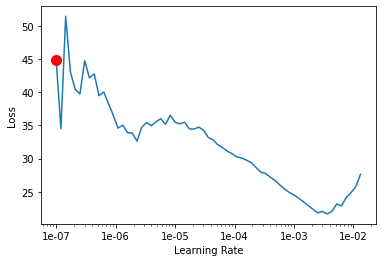

In [ ]:
#lr_find(learn)
learn.lr_find()
learn.recorder.plot(0,2,suggestion=True)

In [ ]:
lr=1e-4

In [ ]:
# learn.load('unetResnet34-BceLoss_ch1-best_dice_multich-stage1-1');
learn.freeze()


## First training
The training has been run with learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting.

In [ ]:
epochs = 10

params = {
    'size': size,
    'epochs': epochs,
    'bs': bs,
    'additionalInfo': 'fit_one_cycle'
}

learn.fit_one_cycle(epochs, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='unetResnet34-BceLoss_ch1-best_dice_multich-stage1-1')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_ch0,iou_ch0,acc_ch1,iou_ch1,time
0,10.973330,4.774999,0.832017,0.840560,0.837351,0.835694,0.826683,0.222724,00:37
1,2.967179,1.766313,0.881768,0.886907,0.861986,0.860867,0.901550,0.378600,00:36
2,1.743487,2.449897,0.889863,0.890381,0.868476,0.867517,0.911250,0.226290,00:36
3,1.180388,0.946800,0.895771,0.899576,0.867759,0.866557,0.923784,0.435034,00:36
4,1.166587,1.253601,0.883588,0.891969,0.870393,0.869355,0.896784,0.439680,00:36
5,1.064353,0.847095,0.894602,0.900544,0.871567,0.870571,0.917637,0.468057,00:36
6,0.824708,0.764654,0.899753,0.903010,0.870486,0.869390,0.929019,0.438955,00:36
7,0.717036,0.656884,0.895408,0.900286,0.870255,0.869128,0.920561,0.452409,00:36
8,0.651957,0.623768,0.896927,0.901239,0.871435,0.870314,0.922420,0.441730,00:36
9,0.621344,0.625176,0.898129,0.902309,0.871190,0.870068,0.925067,0.450635,00:36


Better model found at epoch 0 with dice_multich value: 0.8405600786209106.
Better model found at epoch 1 with dice_multich value: 0.886906623840332.
Better model found at epoch 2 with dice_multich value: 0.8903812170028687.
Better model found at epoch 3 with dice_multich value: 0.89957594871521.
Better model found at epoch 5 with dice_multich value: 0.9005435109138489.
Better model found at epoch 6 with dice_multich value: 0.9030101895332336.


##Second training with unfrozen architecture

In [ ]:
learn.load('unetResnet34-BceLoss_ch1-best_dice_multich-stage1-1');
# learn.load('unetResnet34-focaldice-best-stage2');

In [ ]:
learn.unfreeze()
# learn.summary()

**Training with a smaller learning rate**

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
epochs = 20

params = {
    'size': 256,
    'epochs': epochs,
    'bs': bs,
    'additionalInfo': 'fit_one_cycle-unfrozen'
}


learn.fit_one_cycle(epochs, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='unetResnet34-BceLoss_ch1-best_dice_multich-stage1-1')
                    ]
                   )

## Export final model

In [ ]:
learn.path

In [ ]:
learn.load('unetResnet34-BceLoss_ch1-best_dice_multich-stage1-1');
learn.export(MODEL_PATH + '/export.pkl')